# Funnel distribution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_toy = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
#api_path_sir = os.path.join(cwd, '..', 'tools', 'sir_ais_sampling')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_toy)
#sys.path.append(api_path_sir)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          #xtry_langevin_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from adaptive_sir_loss import *

from flows import RNVP


from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal, 
                           Funnel,
                          Banana, Cauchy)

from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from general_utils import DotDict

from metrics import Evolution

In [4]:
from pathlib import Path
figpath = Path('../figs')

In [5]:
target_args = DotDict()
n_dim = 32
target_args.device = device
target_args.dim = n_dim
target_args.Q =.2
true_target = Banana(target_args).log_prob


loc_proposal = 2.+torch.zeros(n_dim).to(device)
scale_proposal = 3*torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [6]:
true_target_energy = lambda z: - true_target(z)


In [7]:
def plot_hist(samples, title = 'Histogram', bins=200, 
              gamma=0.5, ax_lims = [(-2,9), (-2,4)],
              save_path = 'pics/histogram_test.pdf', density = True):
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    plt.hist2d(samples[:,0], samples[:,1],bins=bins, density=density, range=[ax_lims[0], ax_lims[1]],norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.axis('off')
    plt.xlim((ax_lims[0][0], ax_lims[0][1]))
    plt.ylim((ax_lims[1][0], ax_lims[1][1]))
    plt.savefig(save_path, bbox_inches='tight')
    plt.show() 

In [8]:
### True target

In [9]:
from pyro.infer import MCMC, NUTS, HMC

def energy(z):
    z = z['points']
    return true_target_energy(z).sum()


#kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
kernel_true = NUTS(potential_fn=energy, full_mass = False)
init_samples = proposal.sample((1,))

init_params = {'points': init_samples}
mcmc_true = MCMC(kernel=kernel_true, num_samples = 1000, initial_params=init_params)
mcmc_true.run()

q_true = mcmc_true.get_samples(group_by_chain=True)["points"].squeeze()

Sample: 100%|██████████| 2000/2000 [02:15, 14.76it/s, step size=8.08e-02, acc. prob=0.870]


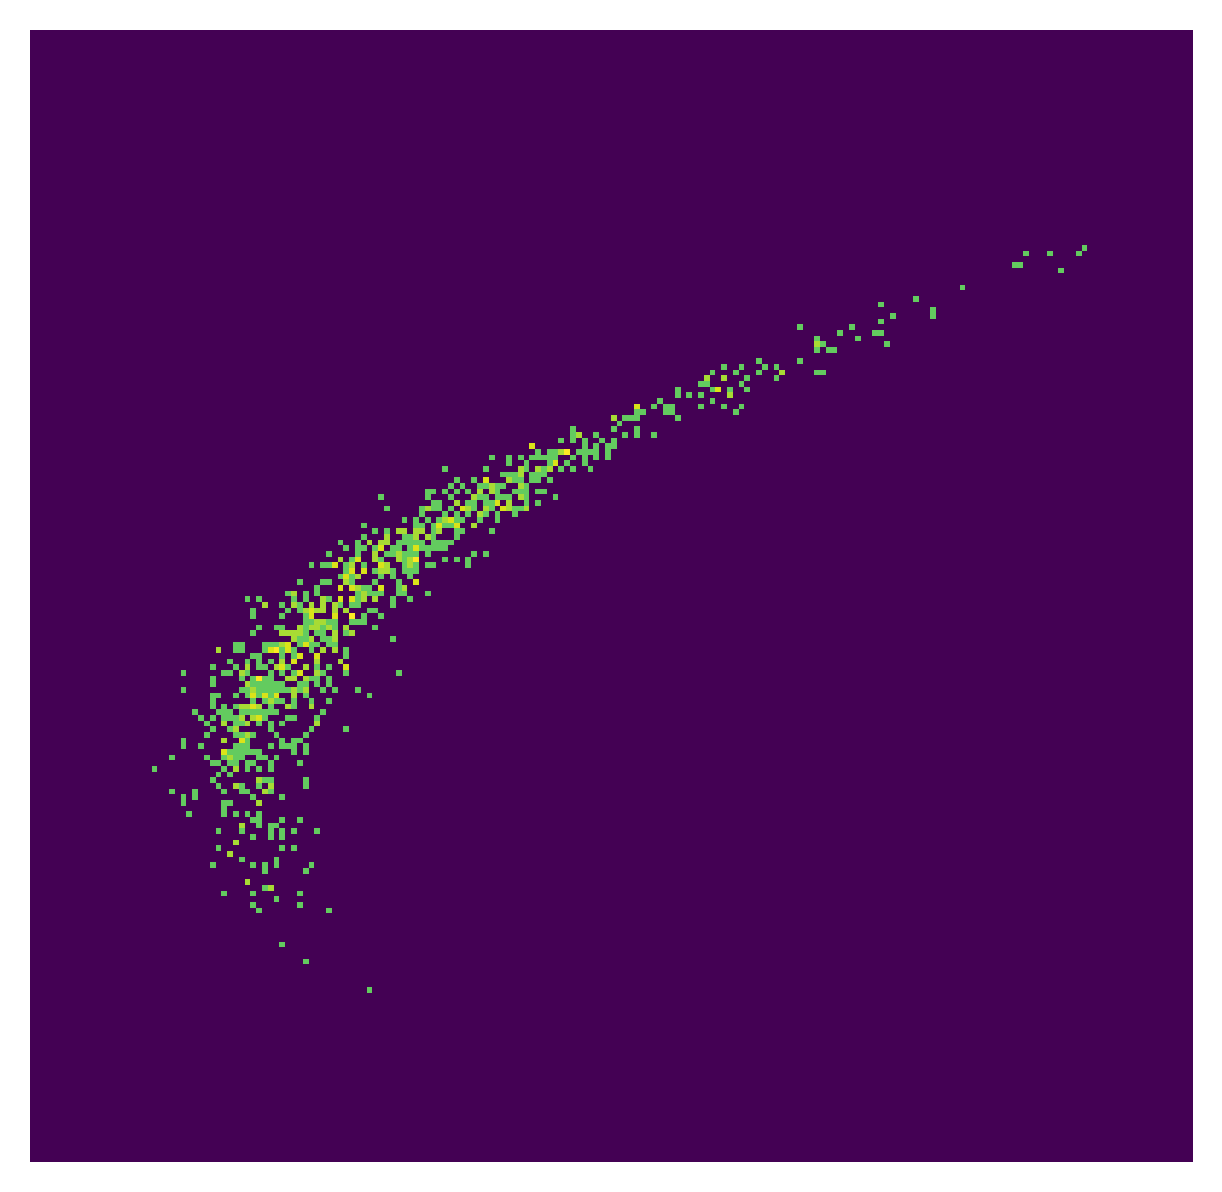

In [10]:
samples_plot_true = np.array(q_true.view(-1, n_dim))
plot_hist(samples_plot_true, title = '', gamma = 0.2,save_path = 'histogram_true_funnel1.pdf')

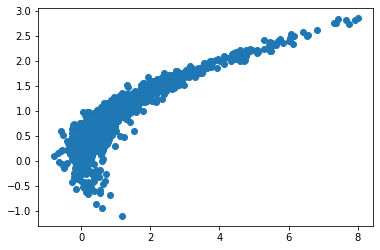

In [11]:
plt.scatter(samples_plot_true[:,0], samples_plot_true[:,1])

## Training with flows

In [65]:
batch_size_sample = 500
loss = "mix_kl" 
flow = RNVP(num_flows = 4, dim = n_dim )

In [66]:
params = flow.parameters()
optimizer = get_optimizer(params, optimizer = "Adam", lr = 1e-3, weight_decay=1e-3)

In [67]:
z_0 = proposal.sample((batch_size_sample,))
z_0.shape

torch.Size([500, 32])

In [68]:
z_1, _ = flow(z_0)

In [69]:
((z_1 - z_0)**2).sum(1)

tensor([12.7985,  6.1539,  5.7840,  5.4234,  7.4967,  6.2925,  6.4972,  9.1232,
         6.0309, 10.1114,  9.8223,  9.6534, 10.0604, 11.5572,  8.8737, 13.9161,
         9.5823,  3.6782, 10.3592,  5.3938, 11.0618,  8.4621,  6.3025,  9.1198,
        12.2209,  7.1235, 12.1688, 10.4598,  7.7154,  7.9680,  9.1569,  5.4517,
         8.8220,  8.6520,  5.2802,  7.9450, 11.5439, 10.6052, 12.9610, 14.5900,
        18.5205,  9.8670,  9.9780, 13.7080, 13.0581,  8.8696, 14.1406,  9.2044,
        10.9205,  9.1191,  8.6894, 12.6751,  9.2577,  6.7017,  8.1705, 10.3622,
         6.8883, 14.8709,  9.8864, 15.0422,  7.4894,  6.4003, 10.7060, 11.6064,
        12.9986, 10.5588,  7.7170,  7.3068, 14.3565, 11.3849, 11.2648,  8.7044,
         7.8348,  8.1910,  5.8559,  7.4449,  7.9883, 13.1107, 13.6868,  5.1909,
        12.7863,  9.9028, 10.7084,  4.0077,  8.7936, 10.8725,  7.8242,  5.5511,
         7.4338,  3.7768,  7.6638,  8.0765, 12.1346,  8.3509,  9.3163,  4.7678,
         9.9628, 11.1046,  9.9490, 11.77

In [70]:
loss_function = get_loss(loss)

In [71]:
N_optim = 1000
alpha = 0.
n_steps = 1
N = 5
grad_step = 2e-3
noise_scale = (2*grad_step)**.5
losses = []

z_ = z_0.clone()
for i in tqdm(range(N_optim)):
    zl, accept, grad_step = ex2_mcmc_mala(z_, true_target,  proposal, n_steps, N, grad_step, (2*grad_step)**.5, 
                        mala_steps = 100, corr_coef=.9, bernoulli_prob_corr=0.3, flow=flow,adapt_stepsize=True)
    #zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, alpha, flow)
    #print(zl)
    z_ = zl[-1]
    #print(z_.shape)
    loss, grad_loss = loss_function(true_target, proposal, flow, z_, alpha = i/(2*N_optim)+.5)
    losses.append(loss.detach().numpy())
    verbose = 50
    if i%verbose == 0:
        print("loss = ", np.mean(losses[-verbose:]))
        print("grad_step = ", grad_step)
        print("mean acceptance = ", accept.mean().numpy()*100,"%")

    (grad_loss).backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 1/1000 [00:00<04:10,  4.00it/s]

loss =  -542030.9
grad_step =  1.676790044531101e-05
mean acceptance =  39.95199501514435 %


  5%|▌         | 51/1000 [00:12<03:47,  4.17it/s]

loss =  -4019.3237
grad_step =  0.037358371788246046
mean acceptance =  94.52200531959534 %


 10%|█         | 101/1000 [00:24<03:56,  3.81it/s]

loss =  25262.92
grad_step =  0.037358371788246046
mean acceptance =  95.80400586128235 %


 15%|█▌        | 151/1000 [00:37<03:47,  3.74it/s]

loss =  -2013.0503
grad_step =  0.037358371788246046
mean acceptance =  95.39599418640137 %


 20%|██        | 201/1000 [00:49<03:10,  4.19it/s]

loss =  -1700.185
grad_step =  0.037358371788246046
mean acceptance =  95.93400359153748 %


 25%|██▌       | 251/1000 [01:01<02:54,  4.28it/s]

loss =  -1278.6473
grad_step =  0.037358371788246046
mean acceptance =  96.04201316833496 %


 30%|███       | 301/1000 [01:15<02:47,  4.18it/s]

loss =  -1628.8694
grad_step =  0.037358371788246046
mean acceptance =  96.17801904678345 %


 35%|███▌      | 351/1000 [01:37<04:07,  2.62it/s]

loss =  -1348.3667
grad_step =  0.037358371788246046
mean acceptance =  96.75999283790588 %


 40%|████      | 401/1000 [01:56<03:35,  2.77it/s]

loss =  -1166.7103
grad_step =  0.037358371788246046
mean acceptance =  96.89001441001892 %


 45%|████▌     | 451/1000 [02:11<02:16,  4.03it/s]

loss =  -956.53406
grad_step =  0.037358371788246046
mean acceptance =  97.04000353813171 %


 50%|█████     | 501/1000 [02:28<04:03,  2.05it/s]

loss =  -1107.9644
grad_step =  0.037358371788246046
mean acceptance =  96.51801586151123 %


 55%|█████▌    | 551/1000 [02:51<03:43,  2.00it/s]

loss =  -1201.7692
grad_step =  0.037358371788246046
mean acceptance =  96.37001156806946 %


 60%|██████    | 601/1000 [03:13<02:34,  2.58it/s]

loss =  -2112.5693
grad_step =  0.037358371788246046
mean acceptance =  96.36401534080505 %


 65%|██████▌   | 651/1000 [03:36<02:47,  2.08it/s]

loss =  -1942.8058
grad_step =  0.037358371788246046
mean acceptance =  96.40800952911377 %


 70%|███████   | 701/1000 [03:55<01:55,  2.59it/s]

loss =  -1859.7894
grad_step =  0.037358371788246046
mean acceptance =  96.53799533843994 %


 75%|███████▌  | 751/1000 [04:13<01:01,  4.03it/s]

loss =  -1899.1361
grad_step =  0.037358371788246046
mean acceptance =  96.78199887275696 %


 80%|████████  | 801/1000 [04:29<00:56,  3.50it/s]

loss =  -1719.9083
grad_step =  0.037358371788246046
mean acceptance =  96.58600687980652 %


 85%|████████▌ | 851/1000 [04:43<00:39,  3.81it/s]

loss =  -1862.4131
grad_step =  0.037358371788246046
mean acceptance =  96.60201072692871 %


 90%|█████████ | 901/1000 [04:57<00:24,  4.06it/s]

loss =  -1981.0428
grad_step =  0.037358371788246046
mean acceptance =  96.7020034790039 %


 95%|█████████▌| 951/1000 [05:08<00:12,  4.07it/s]

loss =  -1853.3988
grad_step =  0.037358371788246046
mean acceptance =  96.64599895477295 %


100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


In [72]:
print("loss = ", loss.detach().numpy())
print("grad_step = ", grad_step)

loss =  -2352.0466
grad_step =  0.0002840913646005556


In [73]:
grad_step

0.0002840913646005556

In [74]:
array = []
for s in zl:
    s=s.detach().numpy()
    print(s.shape)
    array.append(s)
np.array(array).shape
samples = np.array(array).reshape(-1, n_dim)


(500, 32)
(500, 32)


(2, 500, 32)

In [75]:
samples = np.array(array).reshape(-1, n_dim)
samples.shape

(1000, 32)

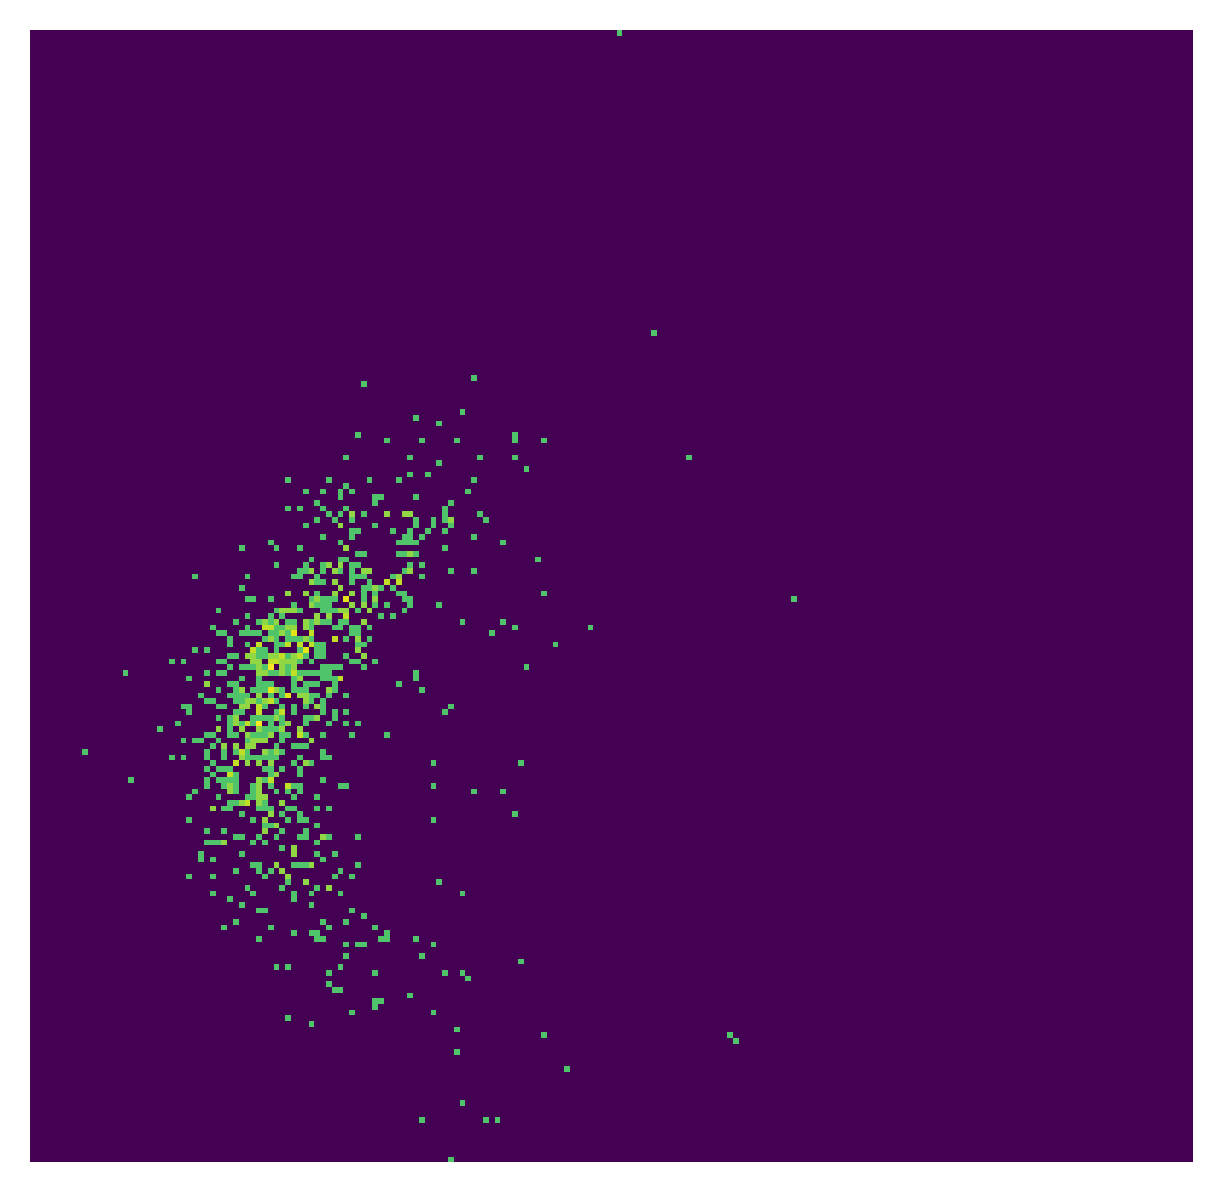

In [76]:
plot_hist(samples, title = '', gamma = 0.2,save_path = 'Ex2MC_wo_flows.pdf')


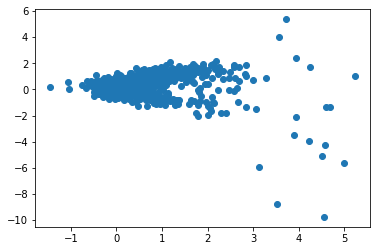

In [77]:
plt.scatter(samples[:,0], samples[:,1])

In [79]:
zl, accept, grad_step = ex2_mcmc_mala(z_, true_target,  proposal, 100, N, grad_step, (2*grad_step)**.5, 
                        mala_steps = 100, corr_coef=.9, bernoulli_prob_corr=0.3, flow=flow,adapt_stepsize=True)
    

In [80]:
array = []
for s in zl:
    s=s.detach().numpy()
    print(s.shape)
    array.append(s)
np.array(array).shape
samples = np.array(array).reshape(-1, n_dim)


(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)
(500, 32)


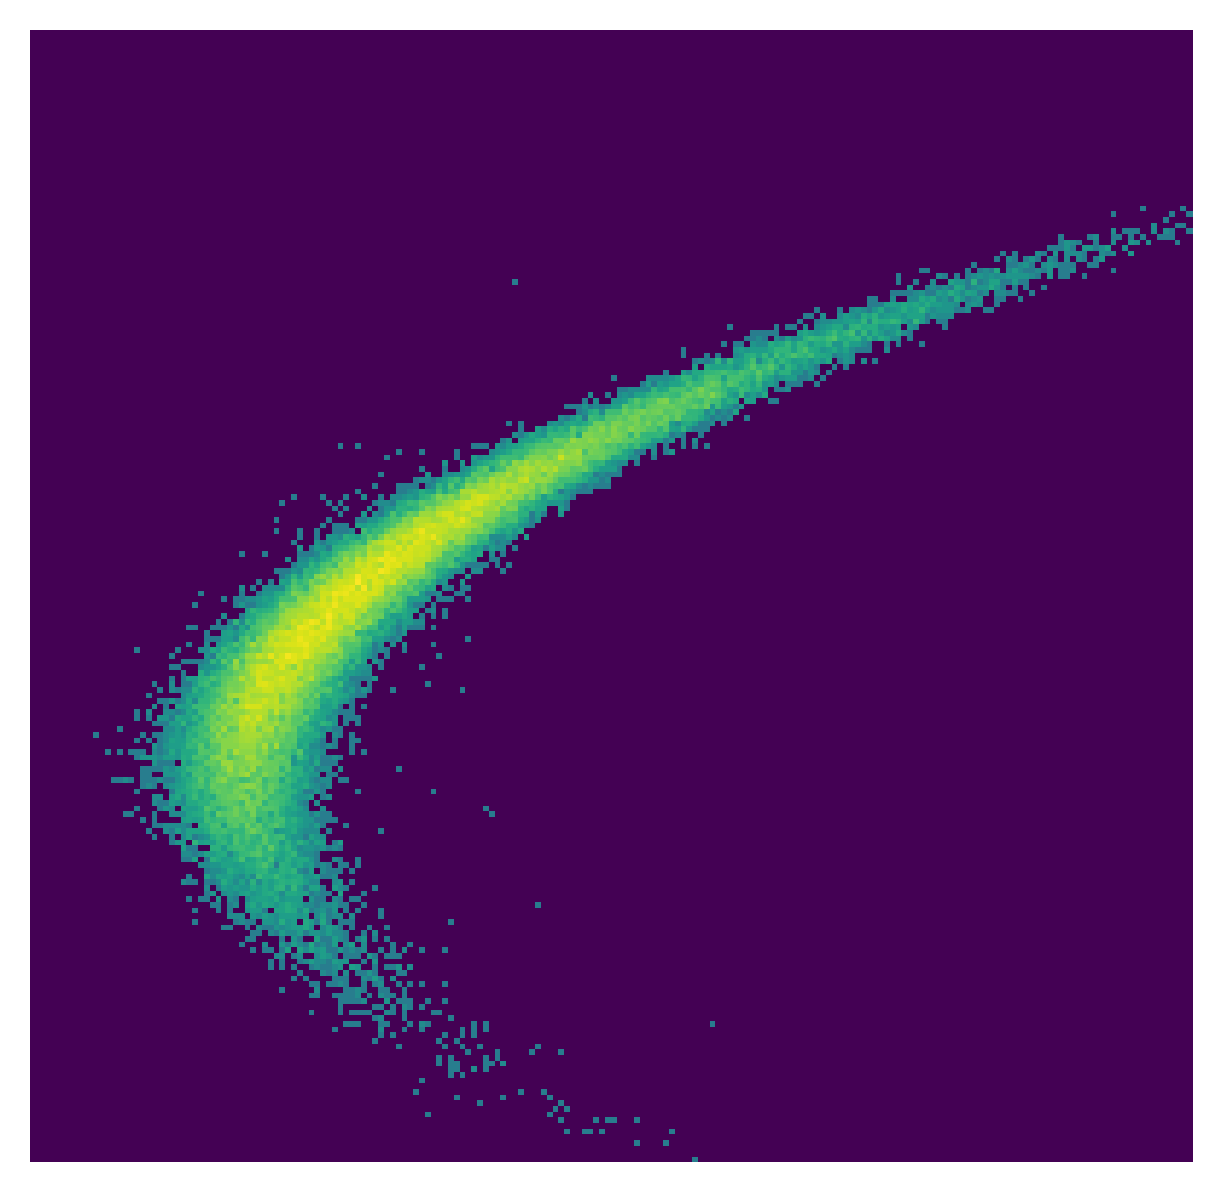

In [81]:
plot_hist(samples, title = '', gamma = 0.2,save_path = 'Ex2MC_wo_flows.pdf')
